In [1]:
!pip install contractions==0.1.72

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.0 MB/s eta 0:00:00


In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from termcolor import colored

from collections import Counter
import re
import nltk
#nltk.download('omw-1.4')
#nltk.download('wordnet2022')
#nlp = load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer
import contractions

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# porter = PorterStemmer()
# lem = WordNetLemmatizer()
# nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


In [4]:
df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv',  header=None)
df.columns = ['Rating', 'Title', 'Review']
df.head(10)

,Rating,Title,Review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


In [5]:
df.shape

(3600000, 3)

In [6]:
# Random Sample Function
def random_sample(data):
    return data.sample(frac = 0.025)

In [7]:
## Check changes
df = random_sample(df)
df.shape

(90000, 3)

In [8]:
df = df[['Rating', 'Review']].reset_index(drop=True)

In [9]:
## Set labels to 0 and 1
def decrease_label_by_one(label):
    return label - 1

df['Rating'] = df['Rating'].apply(decrease_label_by_one)

In [10]:
## Check changes
df.head()

,Rating,Review
0,1,The ladder came just in time to decorate the h...
1,0,This book has got to be possibly the worst sun...
2,0,possibly one of the worst dark future/dystopia...
3,0,"When the feeder is filled to the top, its thin..."
4,0,I bought this book one year ago because there ...


In [11]:
## Count ratings
df.Rating.value_counts(normalize = True)

Rating
0    0.501044
1    0.498956
Name: proportion, dtype: float64

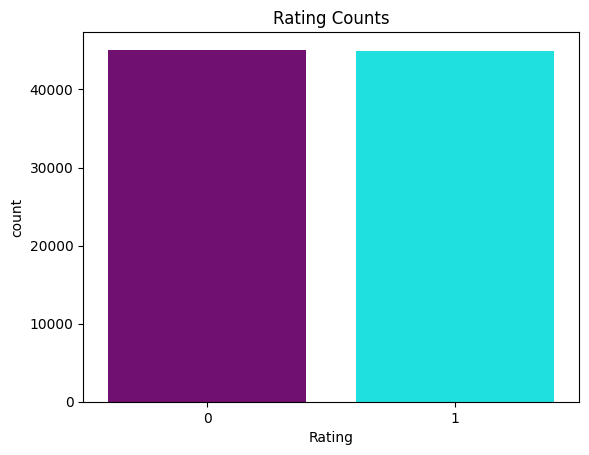

In [12]:
color_palette = ['purple', 'cyan']
sns.set_palette(color_palette)
sns.countplot(x=df['Rating'])

plt.title('Rating Counts')
plt.show()

In [13]:
## Count null values
df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [14]:
def preprocess_text(text):
    # Text clean
    text = re.sub(r'[\W_]+', ' ', contractions.fix(re.sub(r'\d+', '', text.replace(' s ', ' ')))).lower()

    # Stopword removal
    tokens = nltk.word_tokenize(text)
    text = " ".join([token for token in tokens if token not in stop_words])

    # Data Normalization
    normalized_text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(normalized_text)

    return text

In [15]:
print(colored('Before of clean:\n', 'blue'), df.Review[8])
print(colored('After of clean:\n', 'blue'), preprocess_text(df.Review[8]))

Before of clean:
 I got the wolfgang puck rice cooker and its a POS so I have not been able to use this yet. I will re-review later.
After of clean:
 got wolfgang puck rice cooker pos abl use yet review later


In [16]:
## Cleaning and processing on the Review variable
df['Review'] = df['Review'].apply(preprocess_text)

In [17]:
df.head(10)

,Rating,Review
0,1,ladder came time decor hous holiday happi far ...
1,0,book got possibl worst sun sign sex book ever ...
2,0,possibl one worst dark futur dystopian film ev...
3,0,feeder fill top thin plastic side come apart w...
4,0,bought book one year ago good review two autho...
5,0,wast time read book borrow librari anyon trade...
6,0,karaok sesam street one daughter favorit episo...
7,0,design larg could near run color marker ink sl...
8,1,got wolfgang puck rice cooker pos abl use yet ...
9,1,toy offer outstand qualiti lot fun fair price ...


In [18]:
## Frequency Words
words = Counter(' '.join(df['Review'].to_list()).split())
Frequency_words = pd.DataFrame([words]).transpose().reset_index().rename(columns = {'index': 'Words', 0:'Frequency' })
Frequency_words = Frequency_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Frequency_words['Rank'] = Frequency_words['Rank'].apply(lambda x : x+1)
Frequency_words.head(20)

,Rank,Words,Frequency
0,1,book,51473
1,2,one,34332
2,3,like,28521
3,4,would,25414
4,5,read,22383
5,6,good,21632
6,7,use,21519
7,8,get,21365
8,9,time,20448
9,10,great,20375


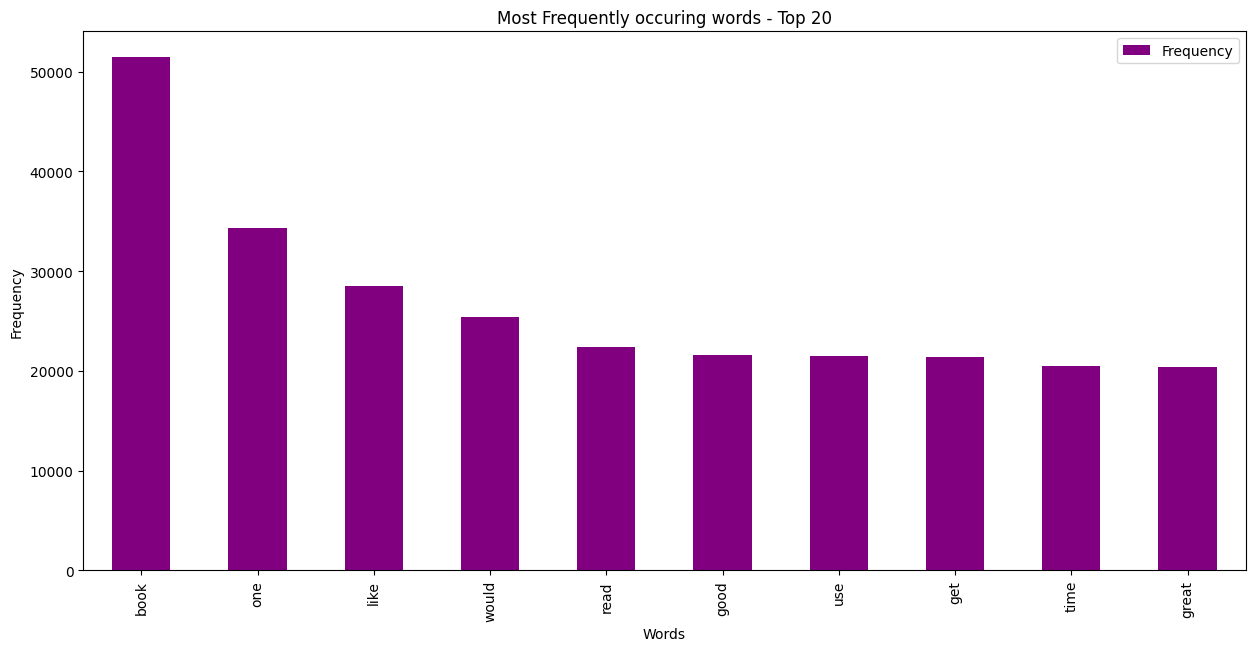

In [19]:
Top10 = Frequency_words[['Words','Frequency']].head(10)
Top10.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'purple')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

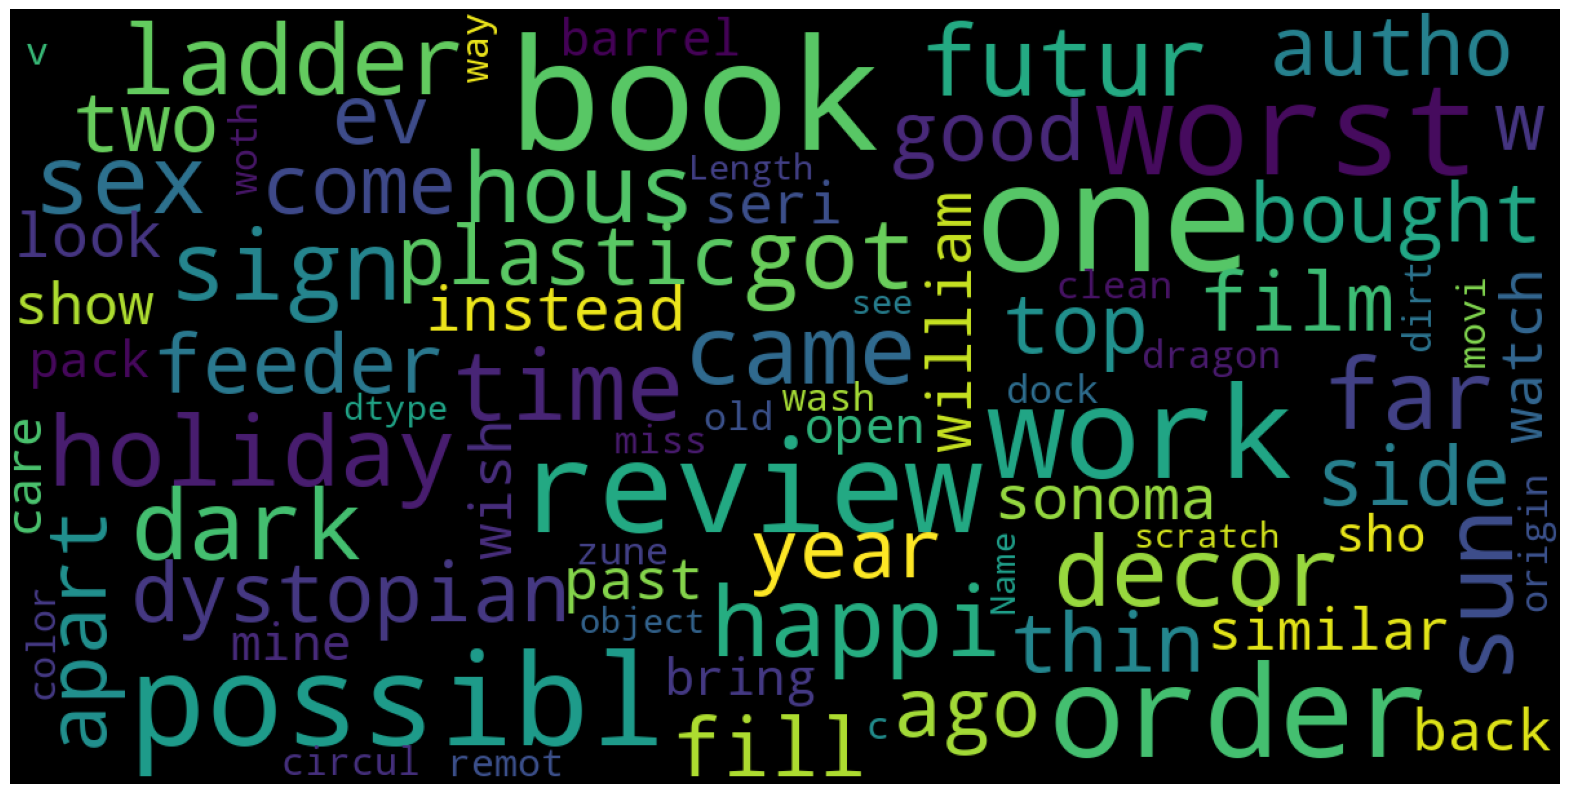

In [20]:
from wordcloud import WordCloud
#  WordCloud chart

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Review"])

In [21]:
Tf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer ='char')
Tf

TfidfVectorizer(analyzer='char', max_features=20000, ngram_range=(1, 3))

In [22]:
X = Tf.fit_transform(df['Review'])
y = df['Rating']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [24]:
lr = LogisticRegression(max_iter=5000)

# Define the preprocessing steps for numeric features
lr.fit(X_train, y_train)

# Evaluate the model on the testing data
lr_preds = lr.predict(X_test)

# Evaluate the accuracy of the model
lr_accuracy = accuracy_score(y_test, lr_preds)*100
print(f"Accuracy of Linear Regression Model: {lr_accuracy:.2f}%")

Accuracy of Linear Regression Model: 81.86%


In [25]:
svm = LinearSVC()

# Define the preprocessing steps for numeric features
svm.fit(X_train, y_train)

# Predict the ratings for the test set
svm_preds = svm.predict(X_test)

# Evaluate the accuracy of the model
svm_accuracy = accuracy_score(y_test, svm_preds)*100
print(f"Accuracy of SVM Model: {svm_accuracy:.2f}%")

Accuracy of SVM Model: 82.51%


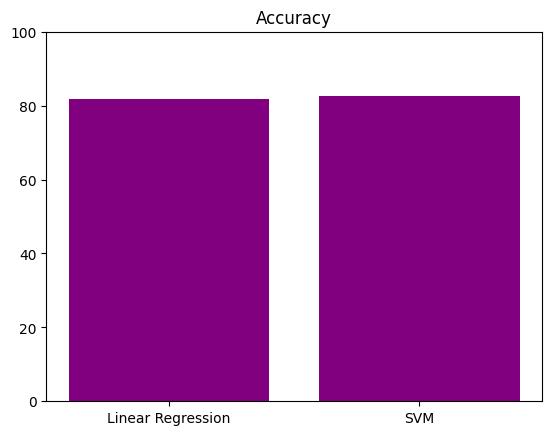

In [26]:
models = ['Linear Regression', 'SVM']
accuracy = [lr_accuracy, svm_accuracy]
plt.bar(models, accuracy)
plt.title('Accuracy')
plt.ylim(0, 100)
plt.show()

In [27]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    average_precision = average_precision_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall Curve')
    plt.fill_between(recall, precision, alpha=0.2, color='navy')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve of {model_name}: AP = {average_precision:.2f}')
    plt.legend(loc="lower left")
    plt.show()

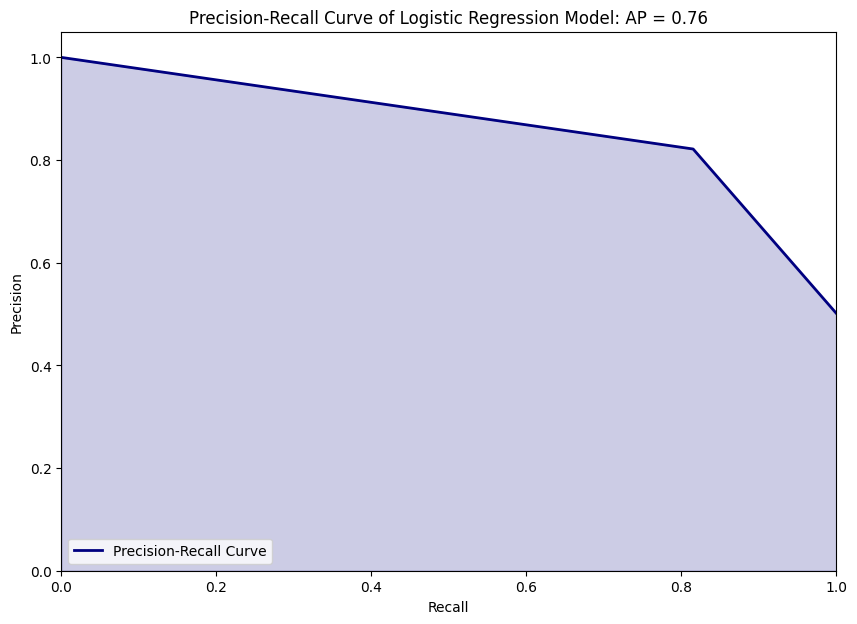

In [28]:
## Precision-Recall Curve of LR model
plot_precision_recall_curve(y_test, lr_preds, 'Logistic Regression Model')

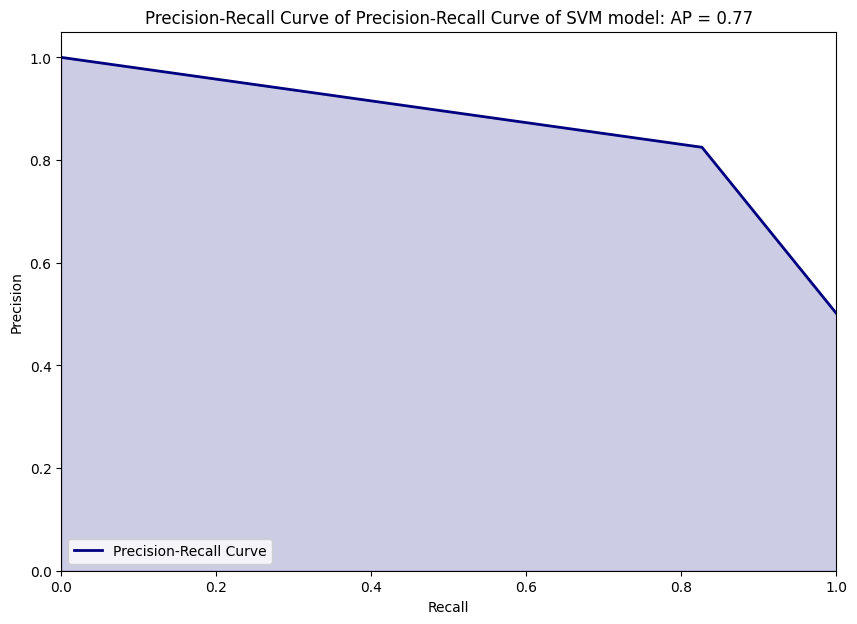

In [29]:
# Precision-Recall Curve of SVM model
plot_precision_recall_curve(y_test, svm_preds, 'Precision-Recall Curve of SVM model')

In [30]:
## Classification report
print(classification_report(y_test,lr_preds))
print(classification_report(y_test,svm_preds))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      8974
           1       0.82      0.82      0.82      9026

    accuracy                           0.82     18000
   macro avg       0.82      0.82      0.82     18000
weighted avg       0.82      0.82      0.82     18000

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      8974
           1       0.82      0.83      0.83      9026

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000



In [31]:
def predict_sentiment(comment, vectorizer, model):
    vec = vectorizer.transform([comment])
    prediction = model.predict(vec)

    if prediction == 0:
        print(colored("Negative", "red"))
    else:
        print(colored("Positive", "blue"))

In [32]:
x = "Lousy product. The quality is very low."
predict_sentiment(x, Tf, svm)

Negative


In [33]:
x1 = "The quality is bad."
predict_sentiment(x1, Tf, lr)

Negative


In [34]:
x2 = "The book is awesome."
predict_sentiment(x2, Tf, svm)

Positive
